In [2]:
#import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train1.csv')
test = pd.read_csv('test1.csv')

### First we will connect our data and try to clean it

In [4]:
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [10]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [124]:
df.isnull().any()

Age             True
Cabin           True
Embarked        True
Fare            True
Name           False
Parch          False
PassengerId    False
Pclass         False
Sex            False
SibSp          False
Survived        True
Ticket         False
dtype: bool

In [125]:
# clean the data, change missing values
df = df.fillna(np.nan)

In [126]:
df[df['Fare'].isnull()==True].index

Int64Index([1043], dtype='int64')

In [6]:
df['Fare'].iloc[1043] = np.mean(df['Fare'])

In [7]:
df['Fare'].iloc[1043]

33.29547928134557

In [8]:
df["Fare"] = df["Fare"].map(lambda x: np.log(x) if x > 0 else 0)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

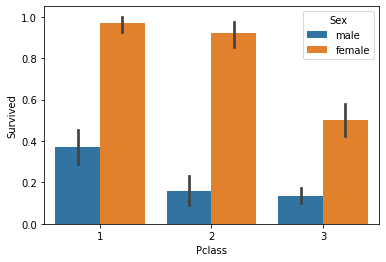

In [13]:
sns.barplot(x='Pclass', y='Survived',hue='Sex',data=df)

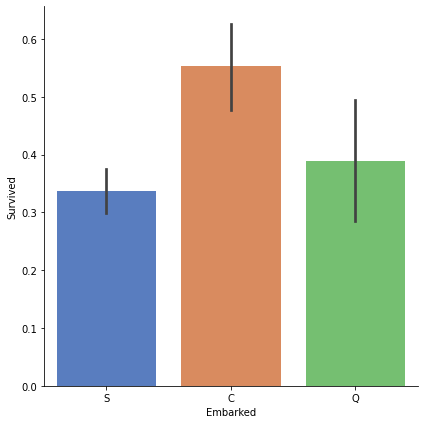

In [15]:
g = sns.factorplot(x="Embarked", y="Survived",  data=df,
                   size=6, kind="bar", palette="muted")

In [15]:
df['Embarked'].isnull().sum()

2

In [16]:
df['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [17]:
df["Embarked"] = df["Embarked"].fillna('C')

In [18]:
for i in range(len(df)):
    df['Name'].iloc[i] = df['Name'].iloc[i][df['Name'].iloc[i].find(',') + 2:df['Name'].iloc[i].find('.')]

In [19]:
df["Embarked"].fillna('C', inplace = True)

In [20]:
df['Sex'] = np.where(df['Sex']=='male', 0, 1)

In [21]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [33]:
df['Cabin'] = df['Cabin'].fillna('T')


'F33'

In [35]:
for i in range(len(df)):
    df['Cabin'].iloc[i] = df['Cabin'].iloc[i][0]

In [36]:
# creating new features based on this columns
df = pd.get_dummies(df, columns = ['Name'])
df = pd.get_dummies(df, columns = ['Embarked'])
df = pd.get_dummies(df, columns = ['Cabin'])

In [37]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Name_Capt', 'Name_Col', 'Name_Don', 'Name_Dona',
       'Name_Dr', 'Name_Jonkheer', 'Name_Lady', 'Name_Major', 'Name_Master',
       'Name_Miss', 'Name_Mlle', 'Name_Mme', 'Name_Mr', 'Name_Mrs', 'Name_Ms',
       'Name_Rev', 'Name_Sir', 'Name_the Countess', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T'],
      dtype='object')

In [38]:
df.drop(labels = ['Ticket'], axis = 1, inplace = True)

In [39]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Name_Capt,Name_Col,...,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,1,0.0,3,0,22.0,1,0,1.981001,0,0,...,0,1,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,4.266662,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,2.070022,0,0,...,0,1,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,3.972177,0,0,...,0,1,0,0,1,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,2.085672,0,0,...,0,1,0,0,0,0,0,0,0,1


In [41]:
train = df[:len(train)]
test = df[len(train):]

In [42]:
test.drop('Survived',axis = 1,inplace=True)

In [43]:
target = train["Survived"]
inputs = train.drop(labels = ['Survived', 'PassengerId'],axis = 1)

In [44]:
input_test = test.drop(labels = ['PassengerId'], axis=1)

In [45]:
#data standartization 
sc = StandardScaler()

In [46]:
inputs = sc.fit_transform(inputs)
input_test = sc.transform(input_test)

In [47]:
input_test

array([[ 0.82737724, -0.73769513,  0.33072307, ..., -0.12168146,
        -0.06715343,  0.54319254],
       [ 0.82737724,  1.35557354,  1.19182279, ..., -0.12168146,
        -0.06715343,  0.54319254],
       [-0.36936484, -0.73769513,  2.22514245, ..., -0.12168146,
        -0.06715343,  0.54319254],
       ...,
       [ 0.82737724, -0.73769513,  0.60627498, ..., -0.12168146,
        -0.06715343,  0.54319254],
       [ 0.82737724, -0.73769513,         nan, ..., -0.12168146,
        -0.06715343,  0.54319254],
       [ 0.82737724, -0.73769513,         nan, ..., -0.12168146,
        -0.06715343,  0.54319254]])

In [48]:
clf1 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=2500,
 max_depth=3,
 min_child_weight=2,
 subsample=0.8,
 colsample_bytree=0.5,
 nthread=3,
 scale_pos_weight=1,
 seed=30)

In [49]:
clf1.fit(inputs, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=2500, n_jobs=3, nthread=3, num_parallel_tree=1,
              random_state=30, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=30, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [50]:
print('Training accuracy...', accuracy_score(target, clf1.predict(inputs)))

Training accuracy... 0.898989898989899


In [51]:
preds = clf1.predict(input_test)

In [52]:
preds

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [53]:
test['Survived'] = preds

In [54]:
test.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Name_Capt,Name_Col,Name_Don,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Survived
891,892,3,0,34.5,0,0,2.057860,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
892,893,3,1,47.0,1,0,1.945910,0,0,0,...,1,0,0,0,0,0,0,0,1,0.0
893,894,2,0,62.0,0,0,2.270836,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
894,895,3,0,27.0,0,0,2.159003,0,0,0,...,1,0,0,0,0,0,0,0,1,0.0
895,896,3,1,22.0,1,1,2.508582,0,0,0,...,1,0,0,0,0,0,0,0,1,0.0
896,897,3,0,14.0,0,0,2.221917,0,0,0,...,1,0,0,0,0,0,0,0,1,0.0
897,898,3,1,30.0,0,0,2.031983,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
898,899,2,0,26.0,1,1,3.367296,0,0,0,...,1,0,0,0,0,0,0,0,1,0.0
899,900,3,1,18.0,0,0,1.978128,0,0,0,...,0,0,0,0,0,0,0,0,1,1.0
900,901,3,0,21.0,2,0,3.184284,0,0,0,...,1,0,0,0,0,0,0,0,1,0.0


In [55]:
cols = ['PassengerId', 'Survived']
submission = test[cols]

In [56]:
submission['Survived'] = submission['Survived'].astype(int)

In [58]:
submission.to_csv('xgb.csv', index = False)